# OWA Wake Modelling Challenge 

## Introduction
This script summarizes the overall results of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).

## Load libraries

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import warnings

from src.BinAvrg import *  
from scipy import interpolate
from IPython.display import Markdown, display
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
%%javascript 
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false
}

<IPython.core.display.Javascript object>

## Sites

In [3]:
n_sites = 5 # number of submited simulations + 1 (ensemble)
sites = pd.DataFrame(columns = ['Name','ID','Data Provider','LON', 'LAT','From','To','Ptot(MW)',
                                'Nt','Turbine Type','P(MW)','D(m)','zhub(m)'],
                     index = np.arange(0,n_sites,1))

sites.loc[0]  = ['Anholt'          , 'anh', 'Ørsted'     , 11.2   , 56.6   , '1-Jan-2013', '30-Jun-2015', 399.6, 111, 'SWT-3.6-120'    , 3.6, 120., 82.]
sites.loc[1]  = ['Dudgeon'         , 'dud', 'Equinor'    , 1.3816 , 53.2585, '1-Dec-2017', '30-Nov-2018', 402. , 67 , 'SWT-6.0-154'    , 6. , 154., 110.]
sites.loc[2]  = ['Rodsand2'        , 'rod', 'EON'        , 11.4610, 54.573 , '1-Feb-2013', '30-Jun-2014', 207. , 90 , 'SWT-2.3-93'     , 2.3, 82.4, 68.5]
sites.loc[3]  = ['WestermostRough' , 'wmr', 'Ørsted'     , 0.1512 , 53.796 , '1-Jan-2016', '31-Dec-2017', 210. , 35 , 'SWT-6.0-154'    , 6. , 154., 106.]
sites.loc[4]  = ['Ormonde'         , 'orm', 'Vattenfall' , -3.444 , 54.0873, '1-Jan-2012', '28-Feb-2019', 150. , 30 , 'Repower-5.0-126', 5. , 126., 100.]

sites.style.set_properties(**{'text-align': 'center'})

,Name,ID,Data Provider,LON,LAT,From,To,Ptot(MW),Nt,Turbine Type,P(MW),D(m),zhub(m)
0,Anholt,anh,Ørsted,11.2,56.6,1-Jan-2013,30-Jun-2015,399.6,111,SWT-3.6-120,3.6,120,82
1,Dudgeon,dud,Equinor,1.3816,53.2585,1-Dec-2017,30-Nov-2018,402,67,SWT-6.0-154,6,154,110
2,Rodsand2,rod,EON,11.461,54.573,1-Feb-2013,30-Jun-2014,207,90,SWT-2.3-93,2.3,82.4,68.5
3,WestermostRough,wmr,Ørsted,0.1512,53.796,1-Jan-2016,31-Dec-2017,210,35,SWT-6.0-154,6,154,106
4,Ormonde,orm,Vattenfall,-3.444,54.0873,1-Jan-2012,28-Feb-2019,150,30,Repower-5.0-126,5,126,100


## Results

In [4]:
# Select which set of results to plot
bench = 'obs' # vs observations 

# Load metrics for all the sites
metrics = dict.fromkeys(sites['ID'])
metrics_bins = dict.fromkeys(sites['ID'])
for i in range(n_sites):
    metrics[sites['ID'][i]] = pd.read_csv('./' + sites["Name"][i] + '/results/' + sites["Name"][i] + '_overall.csv',index_col = 0)
    metrics_bins[sites['ID'][i]]  = pd.read_csv('./' + sites["Name"][i] + '/results/' + sites["Name"][i] + '_bins.csv',index_col = 0)    

for site in sites['ID']:
    metrics[site]['site'] = site 
    metrics[site]['Label'] = (metrics[site]['Participant Number'].apply(str) + '_' + metrics[site]['Participant'] + '_' 
                           + metrics[site]['Model Name'] + '_' + metrics[site]['Model Type'] + '_'  
                           + metrics[site]['External Gradients'] + '_' + metrics[site]['Inflow'])
    metrics_bins[site]['site'] = site 
    metrics_bins[site]['Label'] = (metrics_bins[site]['Participant Number'].apply(str) + '_' + metrics_bins[site]['Participant'] + '_' 
                           + metrics_bins[site]['Model Name'] + '_' + metrics_bins[site]['Model Type'] + '_' 
                           + metrics_bins[site]['External Gradients'] + '_' + metrics_bins[site]['Inflow'])

# Combine all the sites in a single dataframe  
metrics_long = pd.concat([metrics[site] for site in sites['ID']], axis = 0).sort_values('site', ascending=1)
metrics_bins_long = pd.concat([metrics_bins[site] for site in sites['ID']], axis = 0).sort_values('site', ascending=1)

### Overall Metrics

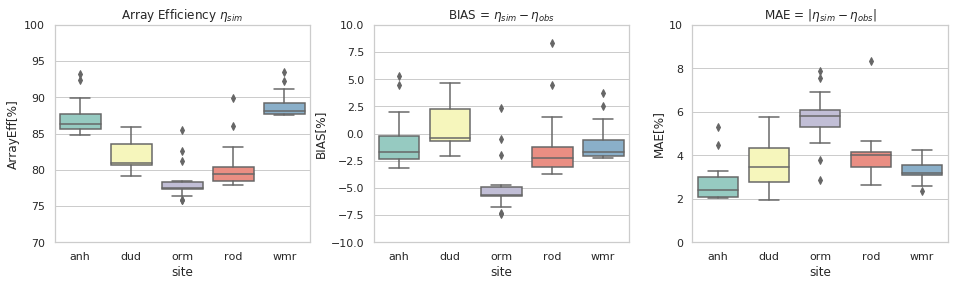

In [5]:
# Overall metrics
sns.set(style="whitegrid", palette="Set3")

fig = plt.figure(figsize=(16, 4))    
ax1 = plt.subplot(1, 3, 1)
ax1 = sns.boxplot(x='site', y='ArrayEff[%]', data = metrics_long)
ax1.set_title('Array Efficiency $\eta_{sim}$')
ax1.set_ylim(70,100)
ax2 = plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x='site', y='BIAS[%]', data = metrics_long)
ax2.set_title('BIAS = $\eta_{{sim}}-\eta_{{{}}}$'.format(bench))
ax2.set_ylim(-10,10)
ax3 = plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x='site', y='MAE[%]', data = metrics_long)
ax3.set_title('MAE = |$\eta_{{sim}}-\eta_{{{}}}$|'.format(bench))
ax3.set_ylim(0,10)
fig.subplots_adjust(wspace=.25);

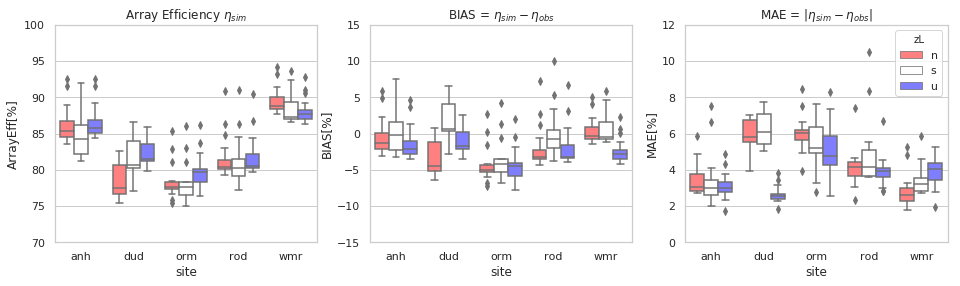

In [6]:
# Overall metrics by stability
metrics_zL = metrics_bins_long.groupby(['site','ID','zL']).mean()
metrics_zL.reset_index(inplace=True)
plt.figure(figsize=(16, 4))    
ax1 = plt.subplot(1, 3, 1)
ax1 = sns.boxplot(x='site', y='ArrayEff[%]', hue = 'zL', data = metrics_zL, palette = 'bwr_r', saturation = 1)
ax1.set_title('Array Efficiency $\eta_{sim}$')
ax1.set_ylim(70,100)
ax1.get_legend().remove()
ax2 = plt.subplot(1, 3, 2)
ax2 = sns.boxplot(x='site', y='BIAS[%]', hue = 'zL', data = metrics_zL, palette = 'bwr_r', saturation = 1)
ax2.set_title('BIAS = $\eta_{{sim}}-\eta_{{{}}}$'.format(bench))
ax2.set_ylim(-15,15)
ax2.get_legend().remove()
ax3 = plt.subplot(1, 3, 3)
ax3 = sns.boxplot(x='site', y='MAE[%]', hue = 'zL', data = metrics_zL, palette = 'bwr_r', saturation = 1)
ax3.set_title('MAE = |$\eta_{{sim}}-\eta_{{{}}}$|'.format(bench))
ax3.set_ylim(0,12);

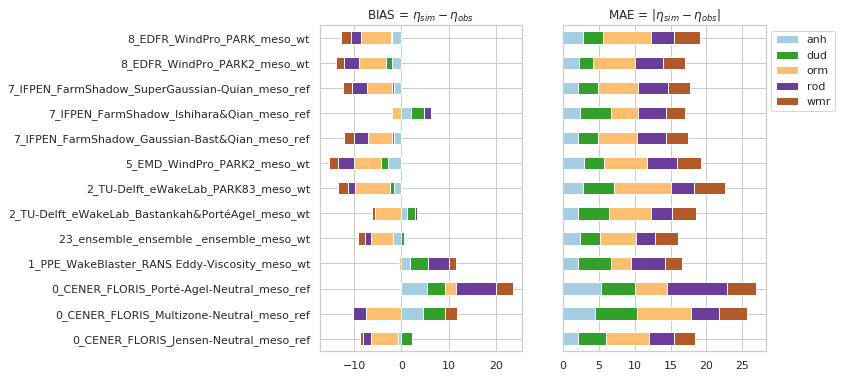

In [7]:
# Overall metrics by model
model_bias = metrics_long.groupby(['site','Label'])['BIAS[%]'].mean().unstack('site')
model_mae = metrics_long.groupby(['site','Label'])['MAE[%]'].mean().unstack('site')

fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all',figsize=(8,6))
model_bias.plot(kind='barh', stacked=True, colormap='Paired', ax = ax[0],
                                  title='BIAS = $\eta_{{sim}}-\eta_{{{}}}$'.format(bench),legend=False)
model_mae.plot(kind='barh', stacked=True, colormap='Paired', ax = ax[1],
                                 title = 'MAE = |$\eta_{{sim}}-\eta_{{{}}}$|'.format(bench))
plt.legend(bbox_to_anchor=(1.0, 1.0))
ax[0].set_ylabel('');


### Bin-based Metrics

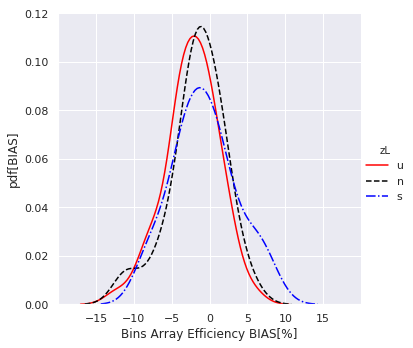

In [8]:
Nmin = 25
# Distribution of bins errors 
label = '23_ensemble_ensemble _ensemble_meso_wt' # select simulation to plot
data = metrics_bins_long[metrics_bins_long['N']>Nmin] # select bins with at least Nmin samples
data = data.loc[data['Label'] == label]
d = {'color': ['r', 'k', 'b'], 'ls' : ['-','--','-.']}
with sns.axes_style("darkgrid"):
    ax1 = sns.FacetGrid(data, hue='zL', height = 5, hue_kws=d) #col = 'site'
    ax1 = (ax1.map(sns.kdeplot, "BIAS[%]",shade=False))
    ax1 = (ax1.set_axis_labels("Bins Array Efficiency BIAS[%]", "pdf[BIAS]")
          .set(xlim=(-20, 20),xticks=[-15,-10,-5,0,5,10,15])
          .add_legend())
    #plt.title(label)

<Figure size 1152x288 with 0 Axes>

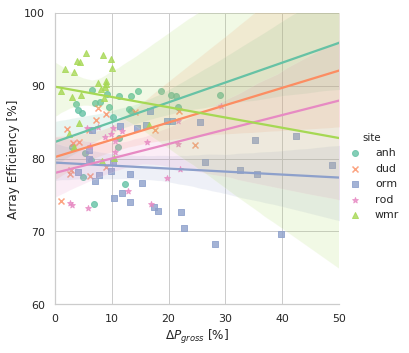

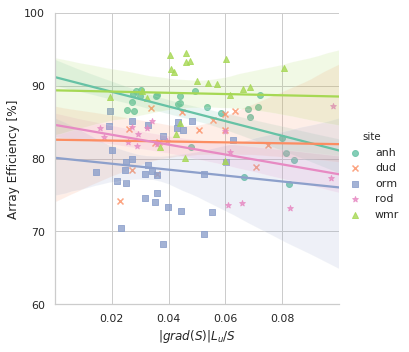

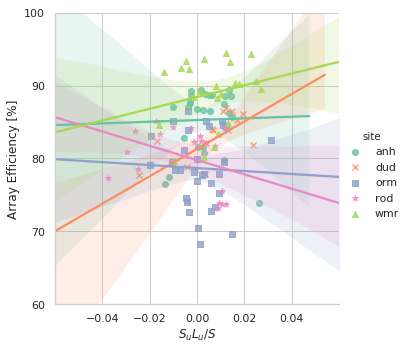

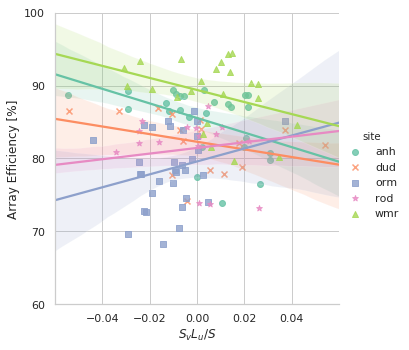

In [14]:
# Impact of Gradients
label = '23_ensemble_ensemble _ensemble_meso_wt'
data = metrics_bins_long[(metrics_bins_long['N']>Nmin) & (metrics_bins_long['Label'] == label)]
sitemarkers = ['o', 'x', 's', '*', '^']
plt.figure(figsize=(16, 4))    
g = sns.lmplot(x="dP", y="ArrayEff[%]", hue="site",
               height=5, data=data,palette="Set2",
               markers=sitemarkers)
g = (g.set_axis_labels('$\Delta P_{gross}$ [%]', "Array Efficiency [%]")
      .set(xlim=(0, 50), ylim=(60, 100),
           xticks=[0,10,20,30,40,50], yticks=[60,70,80,90,100]))


g = sns.lmplot(x="Sh", y="ArrayEff[%]", hue="site",
               height=5, data=data,palette="Set2",
               markers=sitemarkers)
g = (g.set_axis_labels('$|grad(S)|L_{u}/S$', "Array Efficiency [%]")
      .set(xlim=(0, 0.1), ylim=(60, 100),
           xticks=[0.02, 0.04, 0.06, 0.08], yticks=[60,70,80,90,100]))

g = sns.lmplot(x="Su", y="ArrayEff[%]", hue="site",
               height=5, data=data,palette="Set2",
               markers=sitemarkers)
g = (g.set_axis_labels('$S_{u}L_{u}/S$', "Array Efficiency [%]")
      .set(xlim=(-0.06, 0.06), ylim=(60, 100),
           xticks=[-0.04,-0.02,0,0.02,0.04], yticks=[60,70,80,90,100]))

g = sns.lmplot(x="Sv", y="ArrayEff[%]", hue="site",
               height=5, data=data,palette="Set2",
               markers=sitemarkers)
g = (g.set_axis_labels('$S_{v}L_{u}/S$', "Array Efficiency [%]")
      .set(xlim=(-0.06, 0.06), ylim=(60, 100),
           xticks=[-0.04,-0.02,0,0.02,0.04], yticks=[60,70,80,90,100]))